In [1]:
import os, sys
import numpy as np
import pandas as pd
import PIL
from PIL import Image

import torch
import scipy.spatial

sys.path.append('/user_data/mmhender/featsynth/')

# from code_imageanalysis import extract_resnet_features
from code_utils import stats_utils

import matplotlib.pyplot as plt
from matplotlib import cm

things_root = '/user_data/mmhender/stimuli/things/'
project_root = '/user_data/mmhender/featsynth/'
stimuli_folder = 'images_v1'

/home/mmhender/imstat_env/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from code_analysis import analyze_expt1
# analyze_expt1.get_categ_info()

super_names, super_cbinds, basic_names, basic_inds, \
        super_names_long, super_inds_long, n_basic, n_super, n_basic_each_super = \
            analyze_expt1.get_categ_info()

trial_data_all, subjects, subject_cb, cue_level_names, image_type_names = analyze_expt1.load_data()
 
n_subjects = len(subjects)
n_cue_levels = len(cue_level_names)
n_image_types = len(image_type_names)

acc_by_supcat, dprime_by_supcat, acc_by_bascat = analyze_expt1.get_perf_by_categ()

acc_by_condition, dprime_by_condition, propyes_by_condition = analyze_expt1.get_perf_by_cond()

#### Load simclr features from the original things images

In [3]:
image_set_name = 'images_expt1'
image_list_filename = os.path.join(project_root, 'features','raw', '%s_list.csv'%(image_set_name))

labels = pd.read_csv(image_list_filename)

feat_path = os.path.join(project_root, 'features', 'simclr')
image_set_name = 'images_expt1'
training_type='simclr'
feat_all = []

for ll in [2,6,12,15]:
    feat_file_name = os.path.join(feat_path, \
                                          '%s_%s_block%d_pca.npy'%(image_set_name,\
                                                                   training_type, \
                                                                   ll))
    print(feat_file_name)
    feat = np.load(feat_file_name)
    
    feat_all += [feat]
    
feat_all = np.concatenate(feat_all, axis=1)
feat = feat_all

/user_data/mmhender/featsynth/features/simclr/images_expt1_simclr_block2_pca.npy
/user_data/mmhender/featsynth/features/simclr/images_expt1_simclr_block6_pca.npy
/user_data/mmhender/featsynth/features/simclr/images_expt1_simclr_block12_pca.npy
/user_data/mmhender/featsynth/features/simclr/images_expt1_simclr_block15_pca.npy


#### Compute category separability based on cosine dist

In [4]:
within_b = np.zeros((n_basic,))
across_b_within_s = np.zeros((n_basic,))

for bi in range(n_basic):
    
    inds = np.array(labels['basic_index'])==bi
    f = feat[inds,:]

    # comparing images from the same basic-level category
    d = scipy.spatial.distance.pdist(f, metric='cosine')
    
    # average across all pairwise comparisons
    within_b[bi] = np.mean(d.ravel())
    
    # now find all images that are in same super-ordinate category but different basic-level
    si = super_inds_long[bi]
    inds2 = (labels['basic_index']!=bi) & (labels['super_index']==si)
   
    f2 = feat[inds2,:]
    
    # comparing images from same superordinate, different basic-level
    d = scipy.spatial.distance.cdist(f, f2, metric='cosine')

    # average over all pairwise comparisons
    across_b_within_s[bi] = np.mean(d.ravel())
        

# get ratio of across to within
basic_sep = across_b_within_s / within_b 

# average across all the basic-level categs in each super-level
basic_sep_each_supcat = np.array([np.mean(basic_sep[super_inds_long==si]) for si in range(n_super)])

across_b_within_s_each_supcat = np.array([np.mean(across_b_within_s[super_inds_long==si]) for si in range(n_super)])
within_b_each_supcat = np.array([np.mean(within_b[super_inds_long==si]) for si in range(n_super)])

In [5]:
within_s = np.zeros((n_super,))
across_s = np.zeros((n_super,))

for si in range(n_super):
    
    inds = np.array(labels['super_index'])==si
    f = feat[inds,:]

    # comparing images from the same super-level category
    d = scipy.spatial.distance.pdist(f, metric='cosine')
    
    # average across all pairwise comparisons
    within_s[si] = np.mean(d.ravel())
    
    inds2 = np.array(labels['super_index'])!=si
    
    f2 = feat[inds2,:]

    # comparing images from diff super-level
    d = scipy.spatial.distance.cdist(f, f2, metric='cosine')

    # average over all pairwise comparisons
    across_s[si] = np.mean(d.ravel())

# compute ratio of across / within
super_sep_each_supcat = across_s / within_s


#### Params for plotting

In [6]:
cue_level_colors = np.array([[93,192,219], [44,92,168]])/255
point_types = ['o','x']

#### Compute accuracy within each individual categ

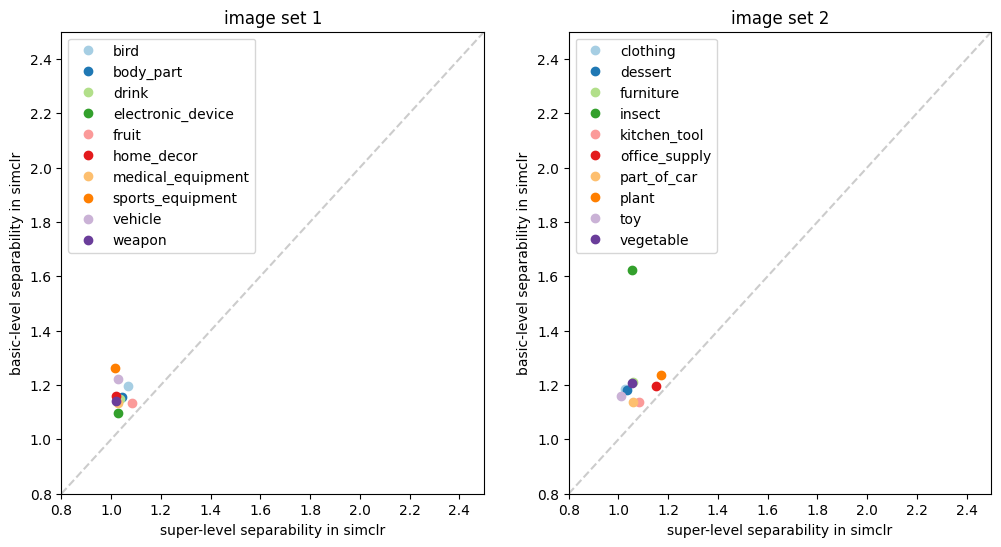

In [7]:
plt.figure(figsize=(12,6))

lims = [0.8, 2.5]

pi=0
for cbi in [0,1]:
        
    pi+=1
    ax = plt.subplot(1,2,pi)
        
    
    supnames = super_names[super_cbinds==cbi]
    
    dist1 = super_sep_each_supcat[super_cbinds==cbi]
    dist2 = basic_sep_each_supcat[super_cbinds==cbi]

    assert(np.all(dist1<lims[1]) & np.all(dist1>lims[0]))
    assert(np.all(dist2<lims[1]) & np.all(dist2>lims[0]))

    basic_colors = cm.Paired(np.linspace(0, 1, 12))[0:10,:]
    # markertypes = np.tile(['.','x','^'],4) 
    markertypes = np.tile(['o'],10) 
    allh = []
    # for bi in [9]:
    for bi in range(len(dist1)):
        
        h, = plt.plot(dist1[bi], dist2[bi], markertypes[bi], color=basic_colors[bi,:], alpha=1)
    
        allh+=[h]
        
    plt.title('image set %d'%(cbi+1))

    plt.xlabel('super-level separability in simclr')
    plt.ylabel('basic-level separability in simclr')

    plt.xlim(lims)
    plt.ylim(lims)
    
    plt.plot(lims,lims, color=[0.8, 0.8, 0.8], linestyle='--')
    
    plt.legend(allh, supnames)

[[0.02605382]
 [0.71417835]] 0.002258703054807021


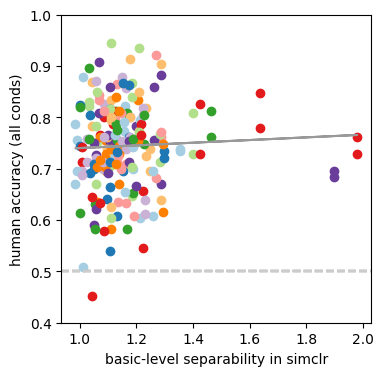

In [8]:
plt.figure(figsize=(4,4))

xvals = []; yvals = [];

for cbi in [0,1]:

    supnames = super_names[super_cbinds==cbi]

    for sc, supcat in enumerate(supnames):
    
        bnames = basic_names[super_names_long==supcat]
       
        # [subjects x cue_levels x image_types x basic_categ]
        vals = acc_by_bascat[cbi][:,:,:,sc,:]
        plot_vals = np.mean(np.mean(vals, axis=1), axis=1)
        meanvals = np.mean(plot_vals, axis=0)
        semvals = np.std(plot_vals, axis=0)/np.sqrt(plot_vals.shape[0])

        n_subs_plot = vals.shape[0]

        dist = basic_sep[super_inds_long==sc]

        basic_colors = cm.Paired(np.linspace(0, 1, 12))[0:10,:]
        # markertypes = np.tile(['.','x','^'],4) 
        markertypes = np.tile(['o'],10) 
        # allh = []
        for bi in range(len(dist)):

            h, = plt.plot(dist[bi], meanvals[bi], markertypes[bi], color=basic_colors[bi,:], alpha=1)
            # plt.errorbar(dist[bi], meanvals[bi], semvals[bi], linestyle='none', color=basic_colors[bi,:])

            # allh+=[h]

        # plt.title('%s'%(supcat))
        
        xvals+=[dist]
        yvals+=[meanvals]

        plt.ylim([0.4, 1.0])
        plt.xlabel('basic-level separability in simclr')
        plt.ylabel('human accuracy (all conds)')
           
        plt.axhline(0.5, color=[0.8, 0.8, 0.8], linestyle='--')

        # box = ax.get_position()
        # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Put a legend to the right of the current axis
        # ax.legend(allh, bnames, loc='center left', bbox_to_anchor=(1, 0.5))

        # plt.legend(allh, bnames)
        
xvals = np.concatenate(xvals, axis=0)
yvals = np.concatenate(yvals, axis=0)

yhat, reg_coeffs, r2 = stats_utils.lin_reg(xvals, yvals)

plt.plot(xvals, yhat, '-', color=[0.6, 0.6, 0.6])
     
print(reg_coeffs, r2)

#### Plot by individual conditions (noisy, 1 trial/subject)

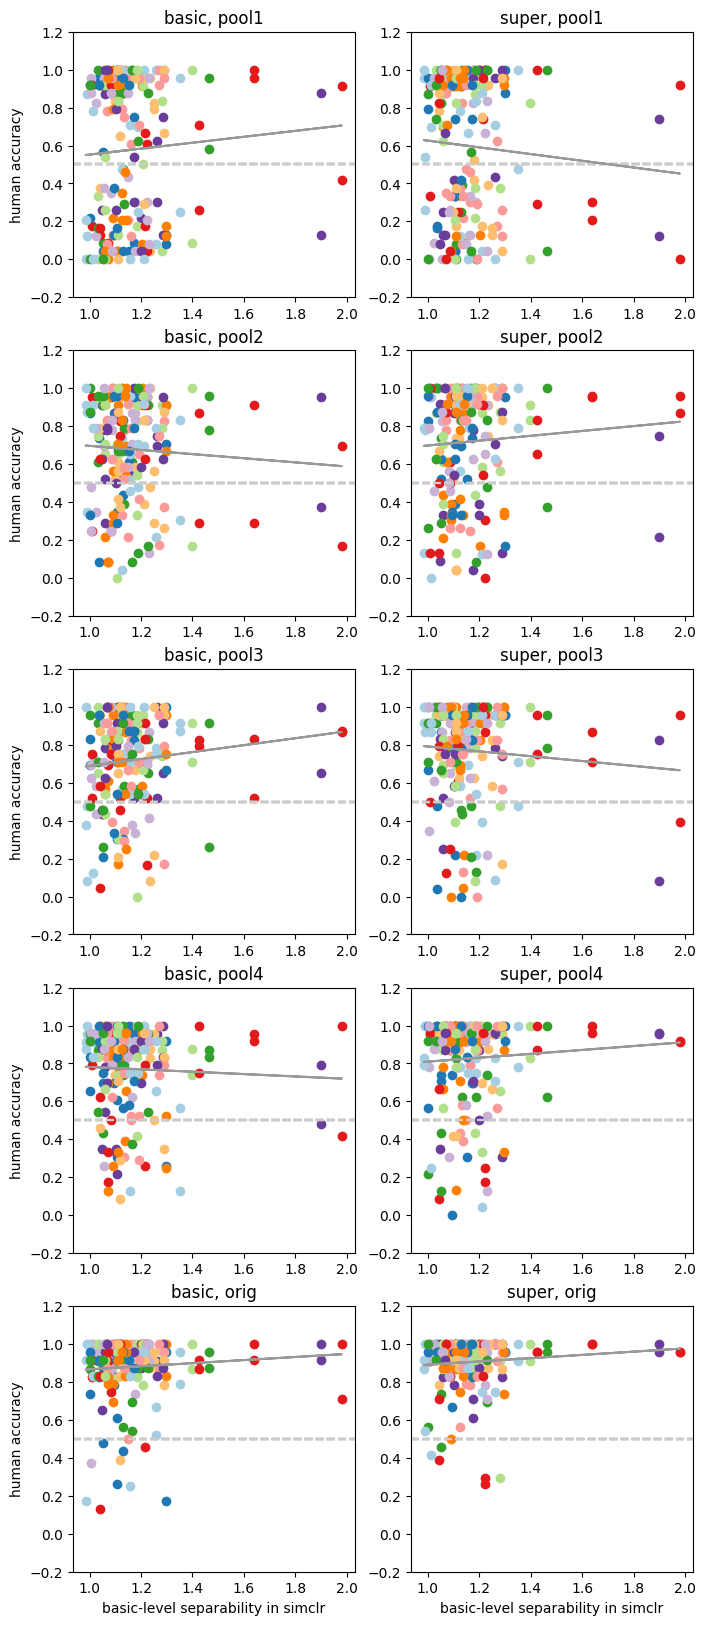

In [10]:
plt.figure(figsize=(8,20))

pi = 0

for ii in range(5):
    
    for cc in range(2):
    
        
        pi+=1
        
        plt.subplot(5,2,pi)

        xvals = []; yvals = [];


        for cbi in [0,1]:

            supnames = super_names[super_cbinds==cbi]

            for sc, supcat in enumerate(supnames):

                bnames = basic_names[super_names_long==supcat]

                # [subjects x basic_categ]
                vals = acc_by_bascat[cbi][:,cc,ii,sc,:]
                # plot_vals = np.mean(np.mean(vals, axis=1), axis=1)
                plot_vals = vals
                meanvals = np.mean(plot_vals, axis=0)
                # semvals = np.std(plot_vals, axis=0)/np.sqrt(plot_vals.shape[0])

                n_subs_plot = vals.shape[0]

                dist = basic_sep[super_inds_long==sc]

                basic_colors = cm.Paired(np.linspace(0, 1, 12))[0:10,:]
                # markertypes = np.tile(['.','x','^'],4) 
                markertypes = np.tile(['o'],10) 
                # allh = []
                for bi in range(len(dist)):

                    h, = plt.plot(dist[bi], meanvals[bi], markertypes[bi], color=basic_colors[bi,:], alpha=1)
                    # plt.errorbar(dist[bi], meanvals[bi], semvals[bi], linestyle='none', color=basic_colors[bi,:])

                    # allh+=[h]

                # plt.title('%s'%(supcat))

                xvals+=[dist]
                yvals+=[meanvals]


                plt.ylim([-0.2, 1.2])
                
                if ii==4:
                    plt.xlabel('basic-level separability in simclr')
                
                if cc==0:
                    plt.ylabel('human accuracy')

                plt.axhline(0.5, color=[0.8, 0.8, 0.8], linestyle='--')

        #         box = ax.get_position()
        #         ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        #         # Put a legend to the right of the current axis
        #         ax.legend(allh, bnames, loc='center left', bbox_to_anchor=(1, 0.5))

            plt.title('%s, %s'%(cue_level_names[cc], image_type_names[ii]))
                # plt.legend(allh, bnames)

        xvals = np.concatenate(xvals, axis=0)
        yvals = np.concatenate(yvals, axis=0)

        # plt.plot(xvals, yvals, 'o', color='b')
        yhat, reg_coeffs, r2 = stats_utils.lin_reg(xvals, yvals)

        plt.plot(xvals, yhat, '-', color=[0.6, 0.6, 0.6])

        # print(reg_coeffs, r2)

#### Plot basic-level separability, averaged within super-ordinate categories

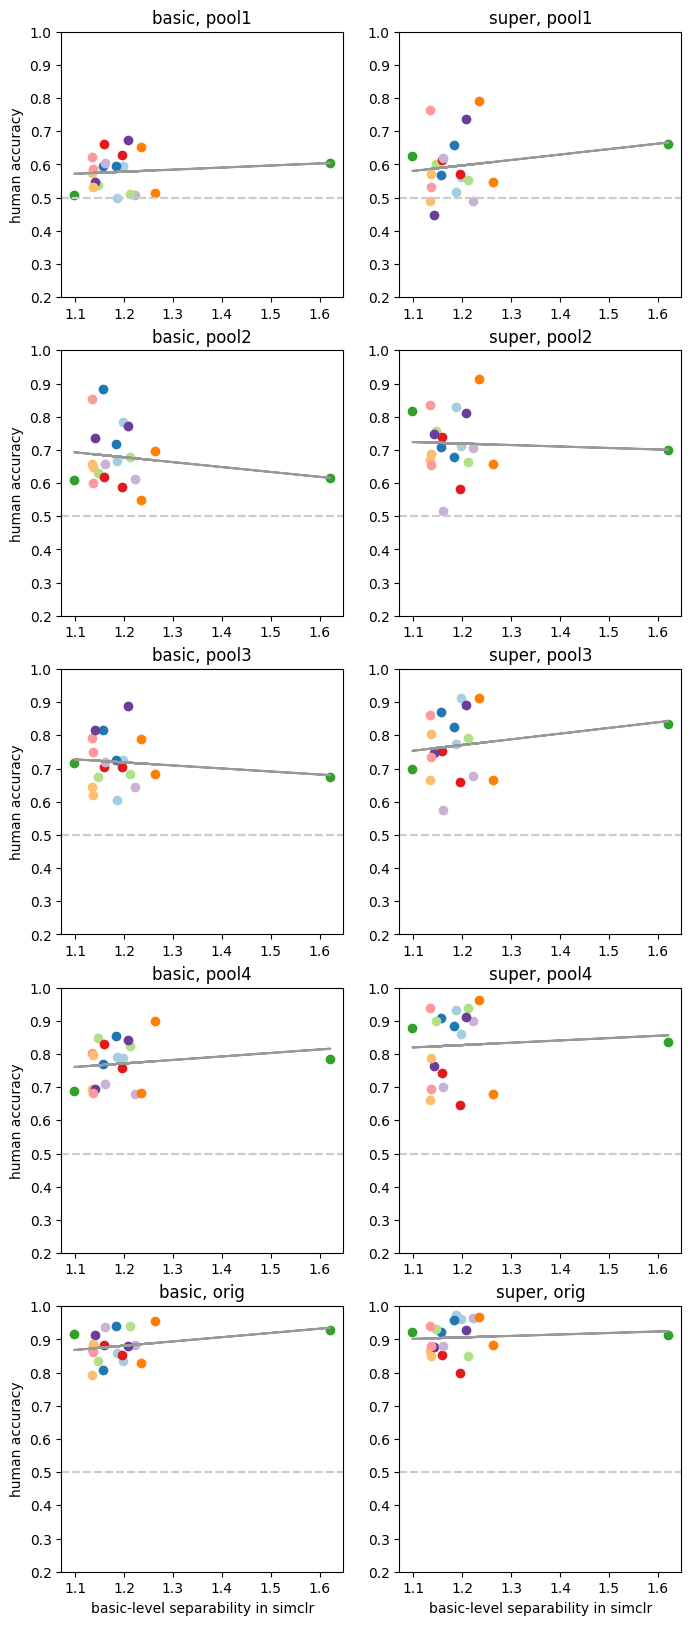

In [11]:
plt.figure(figsize=(8,20))

pi = 0

for ii in range(5):
    
    for cc in range(2):
    
        
        pi+=1
        
        plt.subplot(5,2,pi)

        xvals = []; yvals = [];


        for cbi in [0,1]:

            supnames = super_names[super_cbinds==cbi]

            dist = basic_sep_each_supcat[super_cbinds==cbi]

            # [subjects x basic_categ]
            vals = acc_by_supcat[cbi][:,cc,ii,:]
            # plot_vals = np.mean(np.mean(vals, axis=1), axis=1)
            plot_vals = vals
            meanvals = np.mean(plot_vals, axis=0)
            # semvals = np.std(plot_vals, axis=0)/np.sqrt(plot_vals.shape[0])

            n_subs_plot = vals.shape[0]


            super_colors = cm.Paired(np.linspace(0, 1, 12))[0:10,:]
            # markertypes = np.tile(['.','x','^'],4) 
            markertypes = np.tile(['o'],10) 
            # allh = []
            for si in range(len(dist)):

                h, = plt.plot(dist[si], meanvals[si], markertypes[si], color=super_colors[si,:], alpha=1)
                # plt.errorbar(dist[bi], meanvals[bi], semvals[bi], linestyle='none', color=basic_colors[bi,:])

                # allh+=[h]

            # plt.title('%s'%(supcat))

            xvals+=[dist]
            yvals+=[meanvals]


            plt.ylim([0.2, 1.0])

            if ii==4:
                plt.xlabel('basic-level separability in simclr')

            if cc==0:
                plt.ylabel('human accuracy')

            plt.axhline(0.5, color=[0.8, 0.8, 0.8], linestyle='--')

        #         box = ax.get_position()
        #         ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        #         # Put a legend to the right of the current axis
        #         ax.legend(allh, bnames, loc='center left', bbox_to_anchor=(1, 0.5))

            plt.title('%s, %s'%(cue_level_names[cc], image_type_names[ii]))
                # plt.legend(allh, bnames)

        xvals = np.concatenate(xvals, axis=0)
        yvals = np.concatenate(yvals, axis=0)

        # plt.plot(xvals, yvals, 'o', color='b')
        yhat, reg_coeffs, r2 = stats_utils.lin_reg(xvals, yvals)

        plt.plot(xvals, yhat, '-', color=[0.6, 0.6, 0.6])

        # print(reg_coeffs, r2)

#### Plot super-level separability

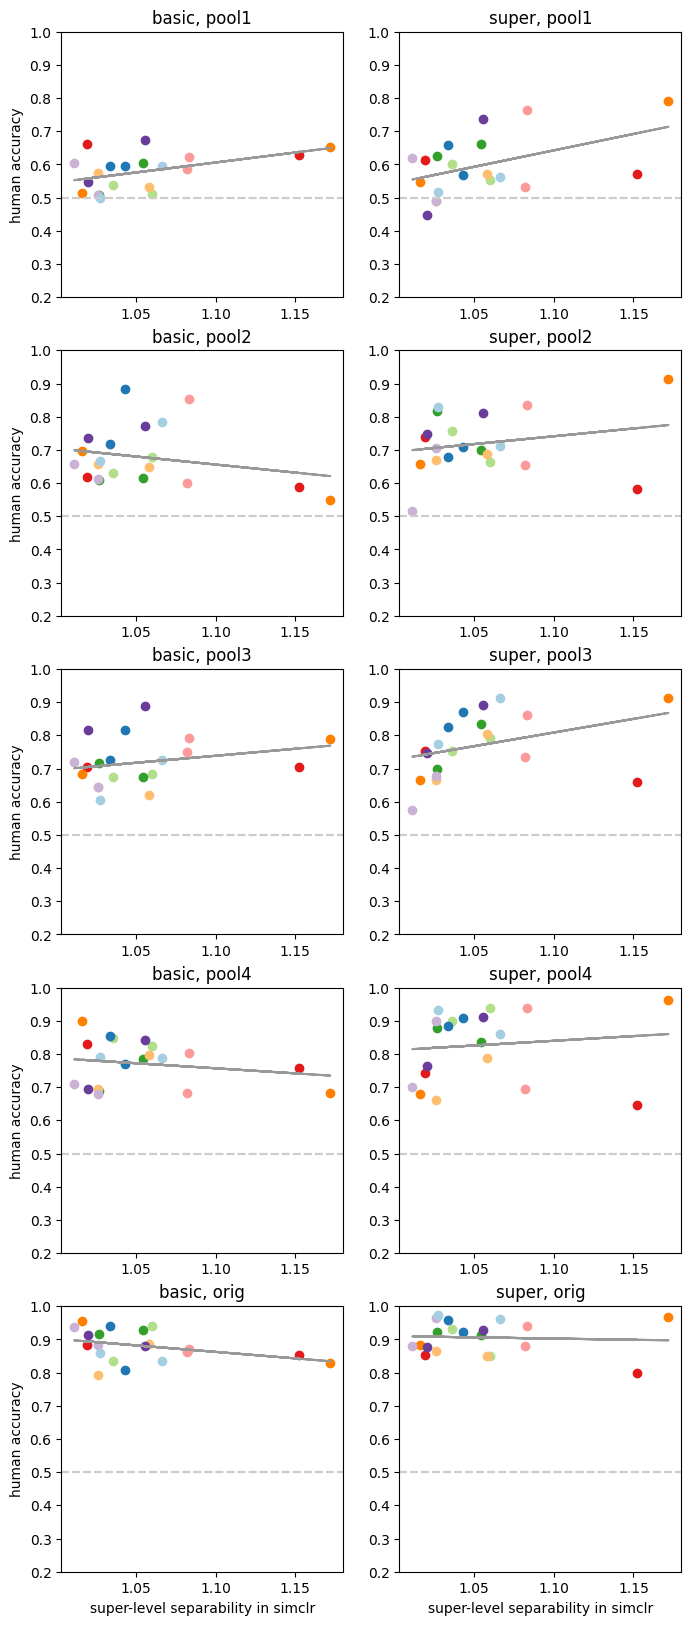

In [12]:
plt.figure(figsize=(8,20))

pi = 0

for ii in range(5):
    
    for cc in range(2):
    
        
        pi+=1
        
        plt.subplot(5,2,pi)

        xvals = []; yvals = [];


        for cbi in [0,1]:

            supnames = super_names[super_cbinds==cbi]

            dist = super_sep_each_supcat[super_cbinds==cbi]

            # [subjects x basic_categ]
            vals = acc_by_supcat[cbi][:,cc,ii,:]
            # plot_vals = np.mean(np.mean(vals, axis=1), axis=1)
            plot_vals = vals
            meanvals = np.mean(plot_vals, axis=0)
            # semvals = np.std(plot_vals, axis=0)/np.sqrt(plot_vals.shape[0])

            n_subs_plot = vals.shape[0]


            super_colors = cm.Paired(np.linspace(0, 1, 12))[0:10,:]
            # markertypes = np.tile(['.','x','^'],4) 
            markertypes = np.tile(['o'],10) 
            # allh = []
            for si in range(len(dist)):

                h, = plt.plot(dist[si], meanvals[si], markertypes[si], color=super_colors[si,:], alpha=1)
                # plt.errorbar(dist[bi], meanvals[bi], semvals[bi], linestyle='none', color=basic_colors[bi,:])

                # allh+=[h]

            # plt.title('%s'%(supcat))

            xvals+=[dist]
            yvals+=[meanvals]


            plt.ylim([0.2, 1.0])

            if ii==4:
                plt.xlabel('super-level separability in simclr')

            if cc==0:
                plt.ylabel('human accuracy')

            plt.axhline(0.5, color=[0.8, 0.8, 0.8], linestyle='--')

        #         box = ax.get_position()
        #         ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        #         # Put a legend to the right of the current axis
        #         ax.legend(allh, bnames, loc='center left', bbox_to_anchor=(1, 0.5))

            plt.title('%s, %s'%(cue_level_names[cc], image_type_names[ii]))
                # plt.legend(allh, bnames)

        xvals = np.concatenate(xvals, axis=0)
        yvals = np.concatenate(yvals, axis=0)

        # plt.plot(xvals, yvals, 'o', color='b')
        yhat, reg_coeffs, r2 = stats_utils.lin_reg(xvals, yvals)

        plt.plot(xvals, yhat, '-', color=[0.6, 0.6, 0.6])

        # print(reg_coeffs, r2)

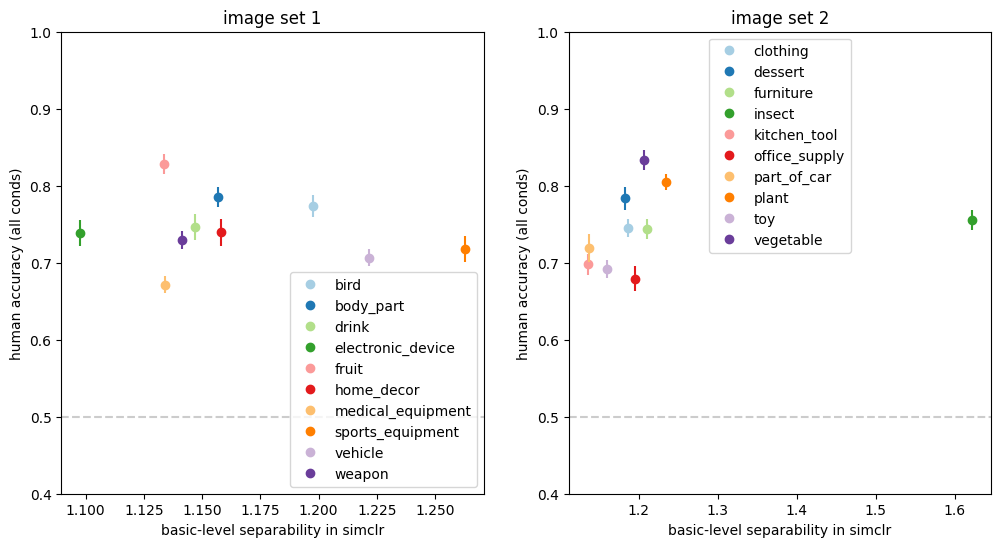

In [13]:
plt.figure(figsize=(12,6))

pi=0

for cbi in [0,1]:
        
    pi+=1
    ax = plt.subplot(1,2,pi)

    vals = acc_by_supcat[cbi]
    plot_vals = np.mean(np.mean(vals, axis=1), axis=1)
    meanvals = np.mean(plot_vals, axis=0)
    semvals = np.std(plot_vals, axis=0)/np.sqrt(plot_vals.shape[0])

    n_subs_plot = vals.shape[0]

    supnames = super_names[super_cbinds==cbi]

    dist = basic_sep_each_supcat[super_cbinds==cbi]

    basic_colors = cm.Paired(np.linspace(0, 1, 12))[0:10,:]
    # markertypes = np.tile(['.','x','^'],4) 
    markertypes = np.tile(['o'],10) 
    allh = []
    for bi in range(len(dist)):
        
        h, = plt.plot(dist[bi], meanvals[bi], markertypes[bi], color=basic_colors[bi,:], alpha=1)
        plt.errorbar(dist[bi], meanvals[bi], semvals[bi], linestyle='none', color=basic_colors[bi,:])

        allh+=[h]
    
    plt.title('image set %d'%(cbi+1))

    plt.ylim([0.4, 1.0])
    # plt.xlim([1.0, 2.5])
    plt.xlabel('basic-level separability in simclr')
    plt.ylabel('human accuracy (all conds)')

    plt.axhline(0.5, color=[0.8, 0.8, 0.8], linestyle='--')
   
    plt.legend(allh, supnames)

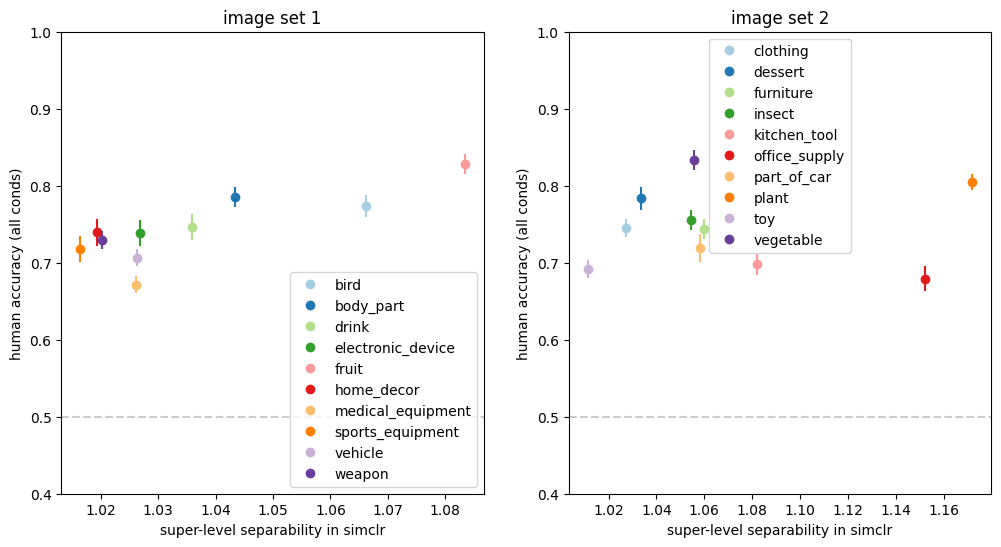

In [14]:
plt.figure(figsize=(12,6))

pi=0

for cbi in [0,1]:
        
    pi+=1
    ax = plt.subplot(1,2,pi)

    vals = acc_by_supcat[cbi]
    plot_vals = np.mean(np.mean(vals, axis=1), axis=1)
    meanvals = np.mean(plot_vals, axis=0)
    semvals = np.std(plot_vals, axis=0)/np.sqrt(plot_vals.shape[0])

    n_subs_plot = vals.shape[0]

    supnames = super_names[super_cbinds==cbi]

    dist = super_sep_each_supcat[super_cbinds==cbi]

    basic_colors = cm.Paired(np.linspace(0, 1, 12))[0:10,:]
    # markertypes = np.tile(['.','x','^'],4) 
    markertypes = np.tile(['o'],10) 
    allh = []
    for bi in range(len(dist)):
        
        h, = plt.plot(dist[bi], meanvals[bi], markertypes[bi], color=basic_colors[bi,:], alpha=1)
        plt.errorbar(dist[bi], meanvals[bi], semvals[bi], linestyle='none', color=basic_colors[bi,:])

        allh+=[h]
    
    plt.title('image set %d'%(cbi+1))

    plt.ylim([0.4, 1.0])
    # plt.xlim([1.0, 2.5])
    plt.xlabel('super-level separability in simclr')
    plt.ylabel('human accuracy (all conds)')

    plt.axhline(0.5, color=[0.8, 0.8, 0.8], linestyle='--')
   
    plt.legend(allh, supnames)

#### Broken down by individual super-categories

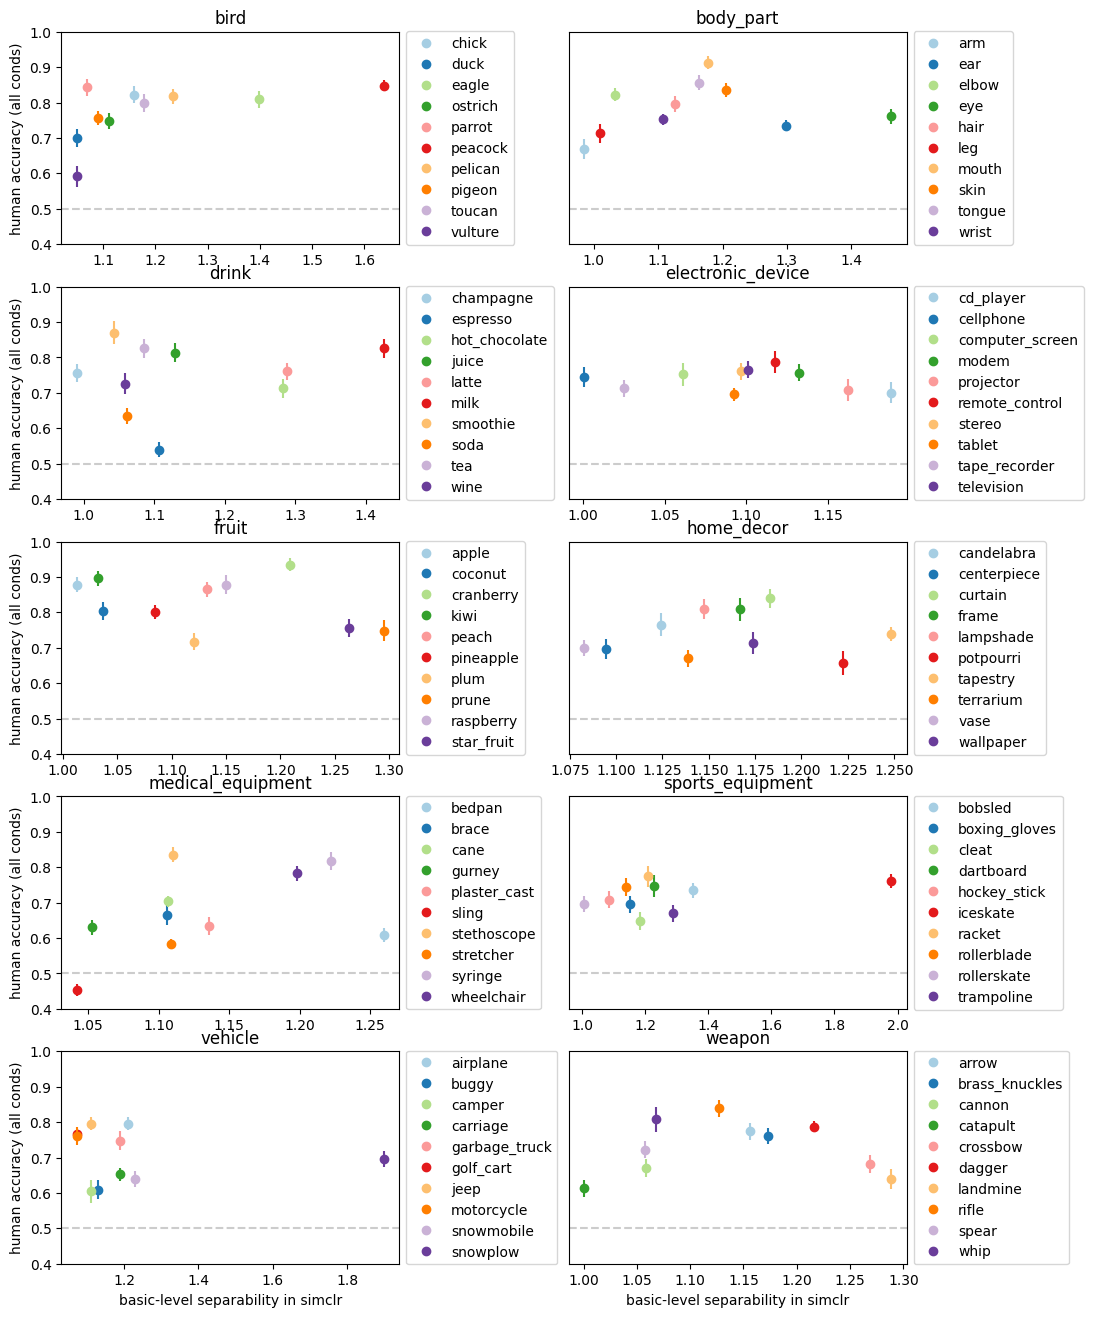

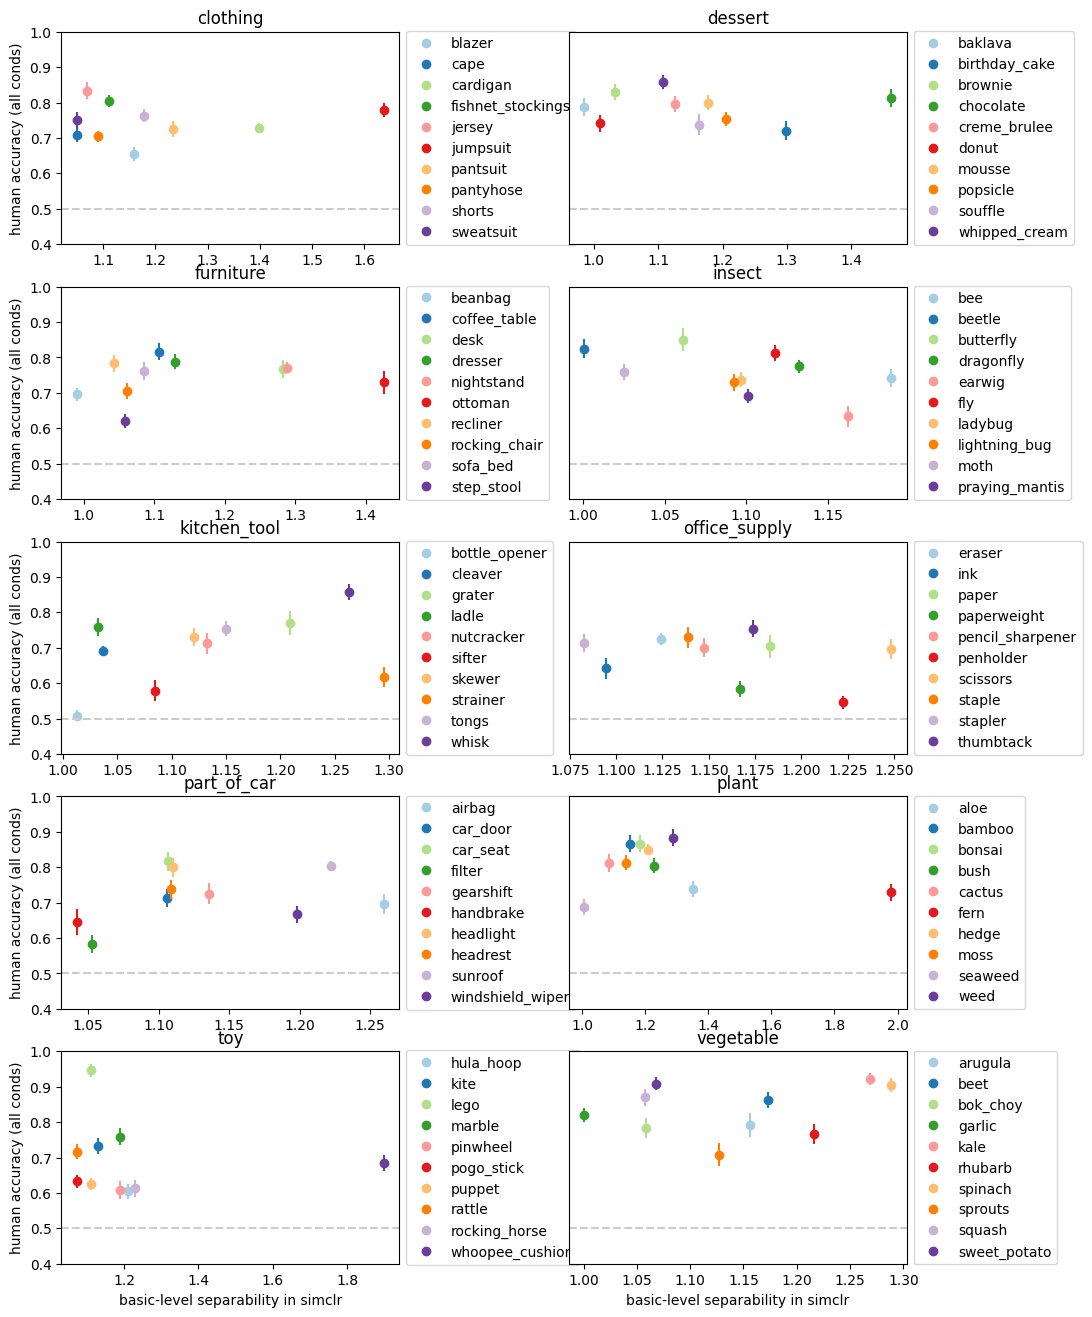

In [15]:
for cbi in [0,1]:
    
    supnames = super_names[super_cbinds==cbi]
      
    plt.figure(figsize=(12,16))

    pi=0
    
    for sc, supcat in enumerate(supnames):
    
        bnames = basic_names[super_names_long==supcat]
                
        pi+=1
        ax = plt.subplot(5,2,pi)

        # [subjects x cue_levels x image_types x basic_categ]
        vals = acc_by_bascat[cbi][:,:,:,sc,:]
        plot_vals = np.mean(np.mean(vals, axis=1), axis=1)
        meanvals = np.mean(plot_vals, axis=0)
        semvals = np.std(plot_vals, axis=0)/np.sqrt(plot_vals.shape[0])

        n_subs_plot = vals.shape[0]

        dist = basic_sep[super_inds_long==sc]

        basic_colors = cm.Paired(np.linspace(0, 1, 12))[0:10,:]
        # markertypes = np.tile(['.','x','^'],4) 
        markertypes = np.tile(['o'],10) 
        allh = []
        for bi in range(len(dist)):

            h, = plt.plot(dist[bi], meanvals[bi], markertypes[bi], color=basic_colors[bi,:], alpha=1)
            plt.errorbar(dist[bi], meanvals[bi], semvals[bi], linestyle='none', color=basic_colors[bi,:])

            allh+=[h]

        plt.title('%s'%(supcat))

        plt.ylim([0.4, 1.0])
        # plt.xlim([1.0, 2.5])
        if sc>7:
            plt.xlabel('basic-level separability in simclr')
        if np.mod(sc,2)==0:
            plt.ylabel('human accuracy (all conds)')
        else:
            plt.yticks([])
            
        plt.axhline(0.5, color=[0.8, 0.8, 0.8], linestyle='--')

        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Put a legend to the right of the current axis
        ax.legend(allh, bnames, loc='center left', bbox_to_anchor=(1, 0.5))

        # plt.legend(allh, bnames)

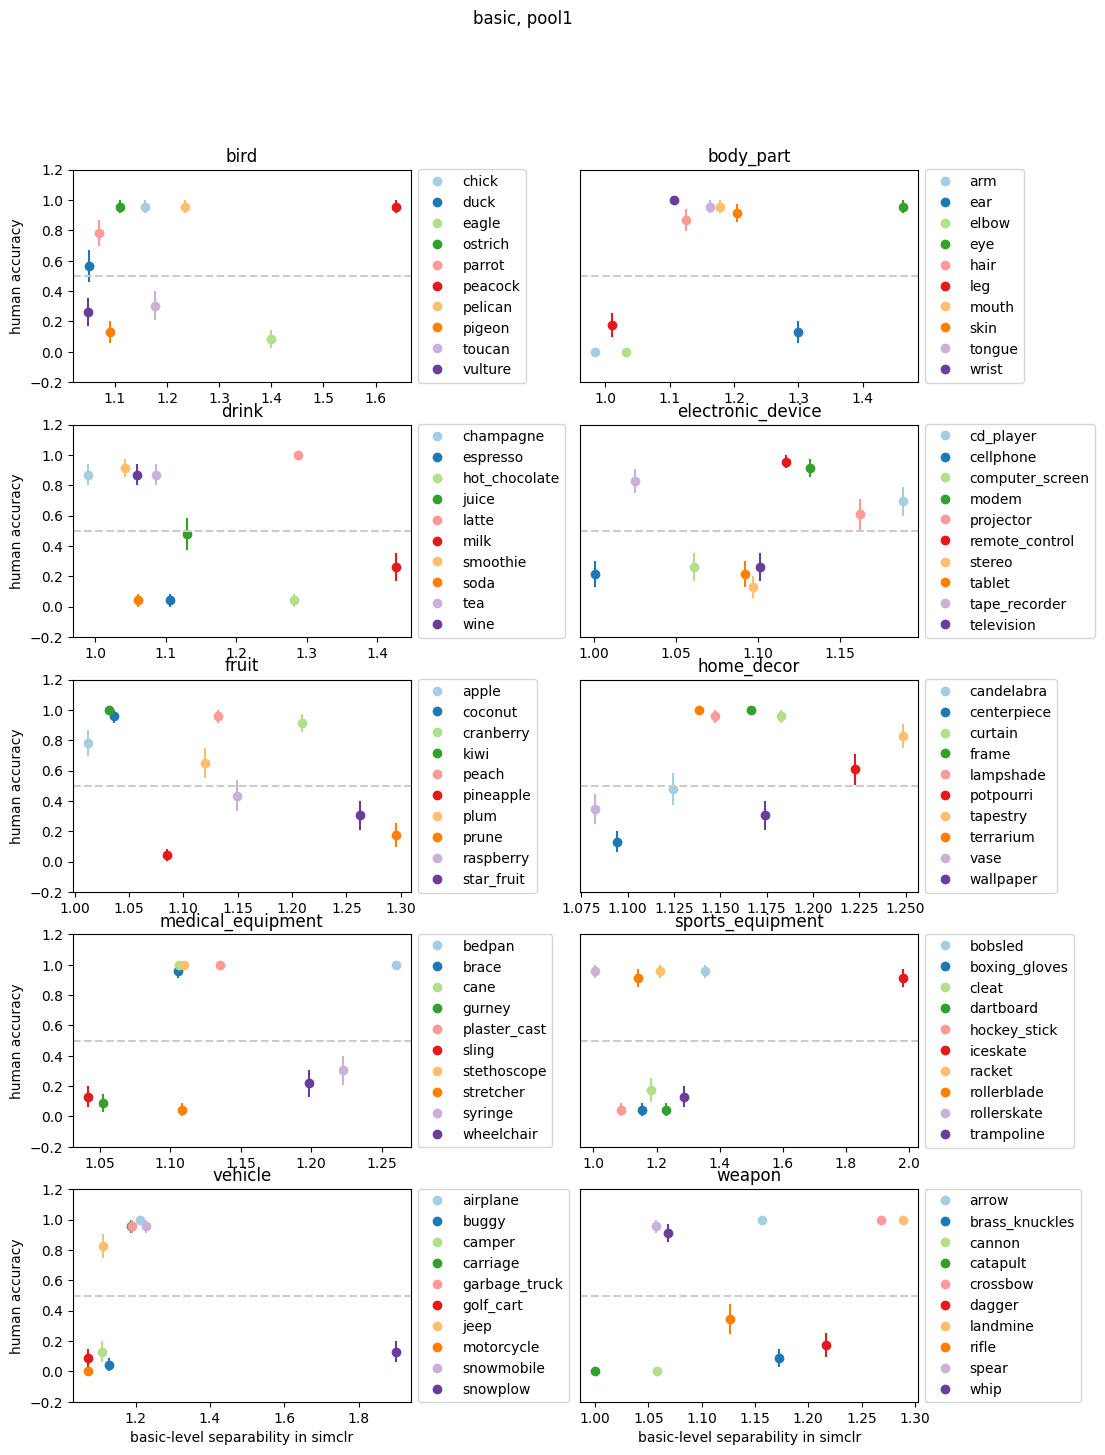

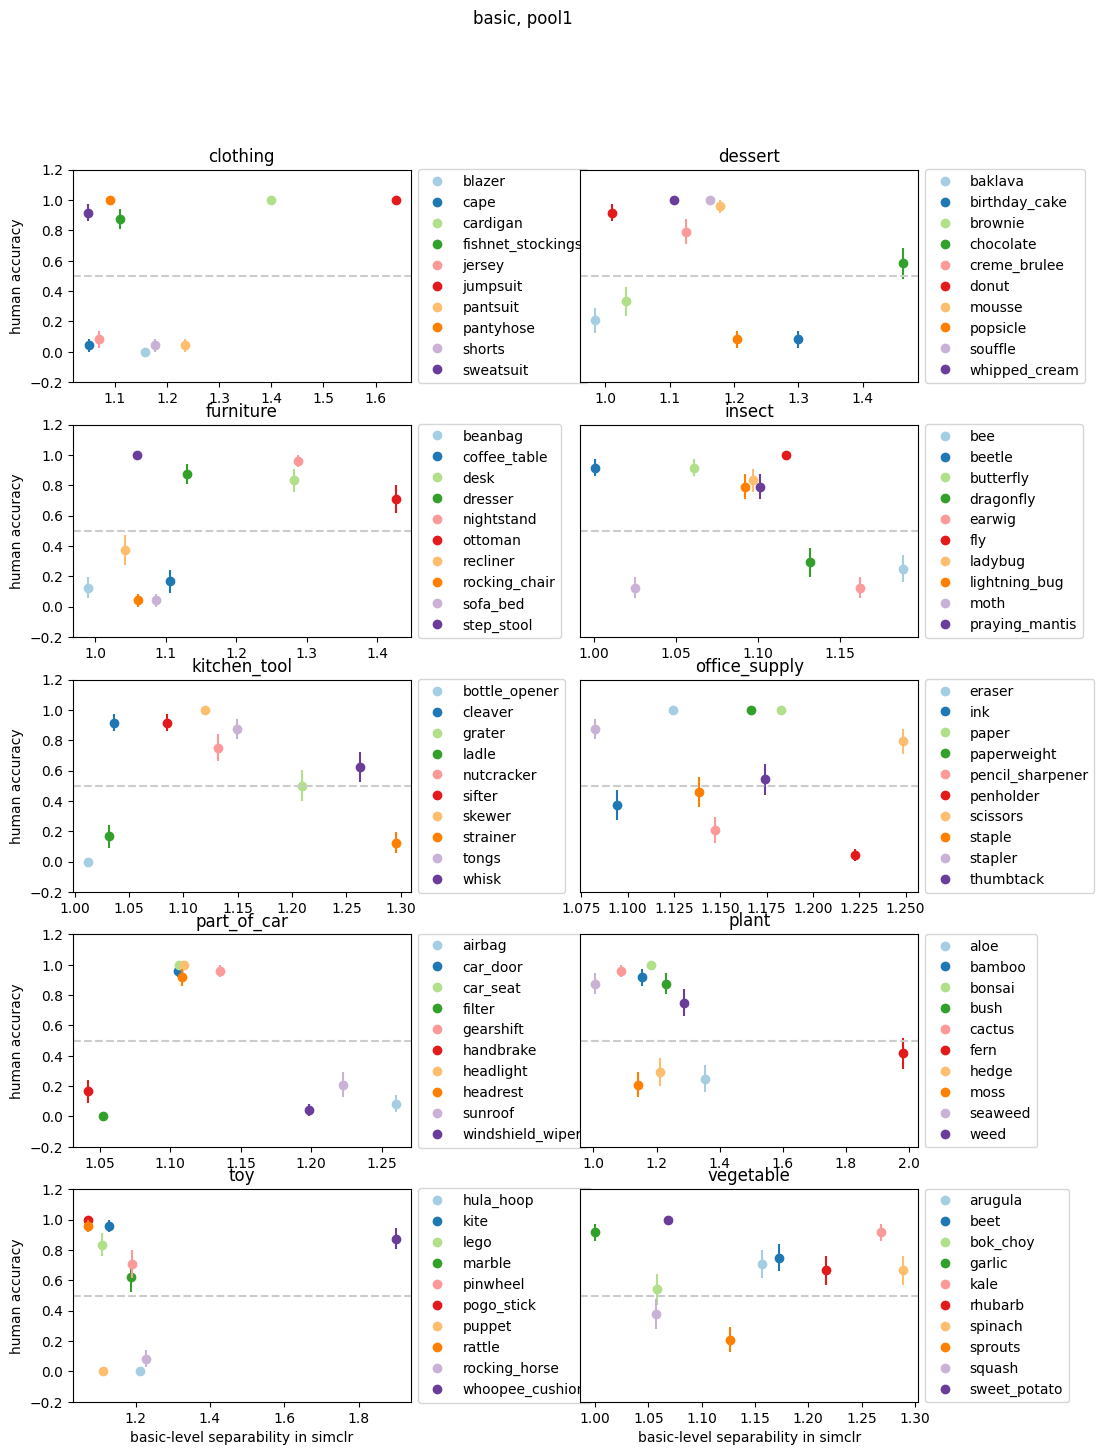

In [16]:
cc = 0;
ii = 0;

for cbi in [0,1]:
    
    supnames = super_names[super_cbinds==cbi]
      
    plt.figure(figsize=(12,16))

    pi=0
    
    for sc, supcat in enumerate(supnames):
    
        bnames = basic_names[super_names_long==supcat]
                
        pi+=1
        ax = plt.subplot(5,2,pi)

        # [subjects x basic_categ]
        vals = acc_by_bascat[cbi][:,cc,ii,sc,:]
        # plot_vals = np.mean(np.mean(vals, axis=1), axis=1)
        plot_vals = vals
        meanvals = np.mean(plot_vals, axis=0)
        semvals = np.std(plot_vals, axis=0)/np.sqrt(plot_vals.shape[0])

        n_subs_plot = vals.shape[0]

        dist = basic_sep[super_inds_long==sc]

        basic_colors = cm.Paired(np.linspace(0, 1, 12))[0:10,:]
        # markertypes = np.tile(['.','x','^'],4) 
        markertypes = np.tile(['o'],10) 
        allh = []
        for bi in range(len(dist)):

            h, = plt.plot(dist[bi], meanvals[bi], markertypes[bi], color=basic_colors[bi,:], alpha=1)
            plt.errorbar(dist[bi], meanvals[bi], semvals[bi], linestyle='none', color=basic_colors[bi,:])

            allh+=[h]

        plt.title('%s'%(supcat))

        plt.ylim([-0.2, 1.2])
        # plt.xlim([1.0, 2.5])
        if sc>7:
            plt.xlabel('basic-level separability in simclr')
        if np.mod(sc,2)==0:
            plt.ylabel('human accuracy')
        else:
            plt.yticks([])
            
        plt.axhline(0.5, color=[0.8, 0.8, 0.8], linestyle='--')

        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Put a legend to the right of the current axis
        ax.legend(allh, bnames, loc='center left', bbox_to_anchor=(1, 0.5))

    plt.suptitle('%s, %s'%(cue_level_names[cc], image_type_names[ii]))
        # plt.legend(allh, bnames)

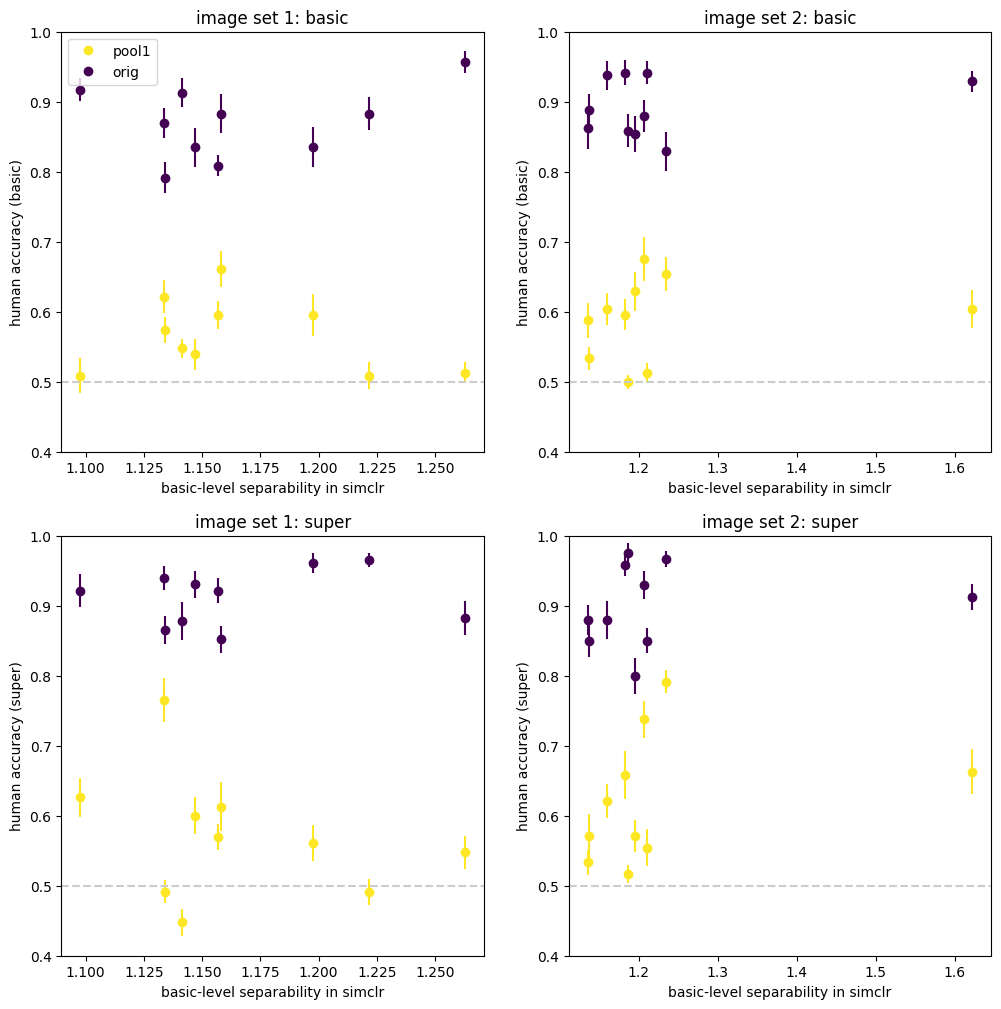

In [17]:
image_type_colors = np.flipud(cm.viridis(np.linspace(0,1,5)))

image_types_plot = [0,4]
# image_types_plot = [0,1,2,3,4]

plt.figure(figsize=(12,12))

pi=0
for cc in [0,1]:
    
    for cbi in [0,1]:
        
        pi+=1
        ax = plt.subplot(2,2,pi)
        
        vals = acc_by_supcat[cbi]
        n_subs_plot = vals.shape[0]
        
        supnames = super_names[super_cbinds==cbi]

        dist = basic_sep_each_supcat[super_cbinds==cbi]

        hlist = []
        for ii in image_types_plot:

            plot_vals = vals[:,cc,ii,:]
            meanvals = np.mean(plot_vals, axis=0)
            semvals = np.std(plot_vals, axis=0)/np.sqrt(plot_vals.shape[0])

            h, = plt.plot(dist, meanvals, 'o', color=image_type_colors[ii,:])
            plt.errorbar(dist, meanvals, semvals, linestyle='none', color=image_type_colors[ii,:])

            hlist+=[h]
        plt.title('image set %d: %s'%(cbi+1, cue_level_names[cc]))

        plt.ylim([0.4, 1.0])
        # plt.xlim([1.0, 2.5])
        plt.xlabel('basic-level separability in simclr')
        plt.ylabel('human accuracy (%s)'%cue_level_names[cc])

        plt.axhline(0.5, color=[0.8, 0.8, 0.8], linestyle='--')
        if pi==1:
            plt.legend(hlist,np.array(image_type_names)[image_types_plot])
        # plt.suptitle('Performance on %s, %s'%(image_type_names[ii], cue_level_names[cc]))

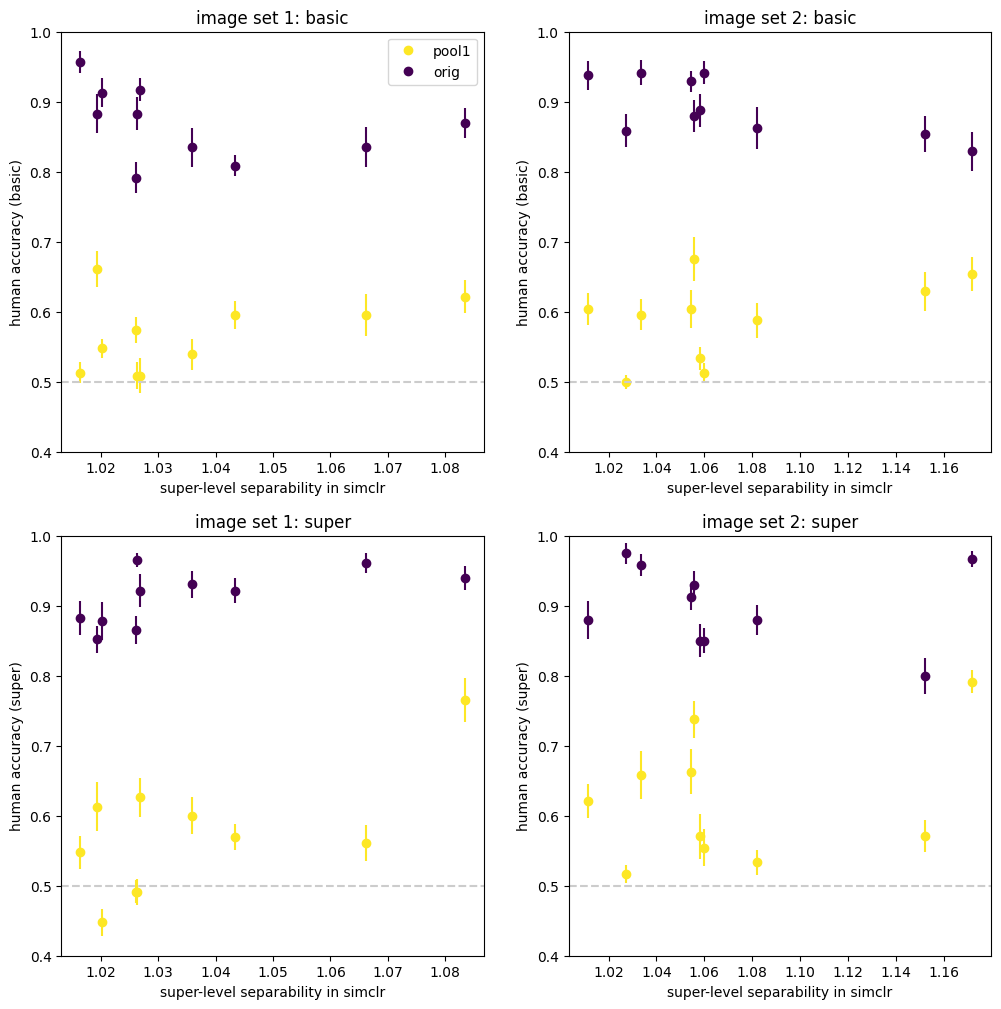

In [18]:
image_type_colors = np.flipud(cm.viridis(np.linspace(0,1,5)))

image_types_plot = [0,4]
# image_types_plot = [0,1,2,3,4]

plt.figure(figsize=(12,12))

pi=0
for cc in [0,1]:
    
    for cbi in [0,1]:
        
        pi+=1
        ax = plt.subplot(2,2,pi)
        
        vals = acc_by_supcat[cbi]
        n_subs_plot = vals.shape[0]
        
        supnames = super_names[super_cbinds==cbi]

        dist = super_sep_each_supcat[super_cbinds==cbi]

        hlist = []
        for ii in image_types_plot:

            plot_vals = vals[:,cc,ii,:]
            meanvals = np.mean(plot_vals, axis=0)
            semvals = np.std(plot_vals, axis=0)/np.sqrt(plot_vals.shape[0])

            h, = plt.plot(dist, meanvals, 'o', color=image_type_colors[ii,:])
            plt.errorbar(dist, meanvals, semvals, linestyle='none', color=image_type_colors[ii,:])

            hlist+=[h]
        plt.title('image set %d: %s'%(cbi+1, cue_level_names[cc]))

        plt.ylim([0.4, 1.0])
        # plt.xlim([1.0, 2.5])
        plt.xlabel('super-level separability in simclr')
        plt.ylabel('human accuracy (%s)'%cue_level_names[cc])

        plt.axhline(0.5, color=[0.8, 0.8, 0.8], linestyle='--')
        if pi==1:
            plt.legend(hlist,np.array(image_type_names)[image_types_plot])
        # plt.suptitle('Performance on %s, %s'%(image_type_names[ii], cue_level_names[cc]))